In [ ]:
path = []


In [ ]:
path = [[0, 10], [1, 9], [2, 9], [3, 10], [4, 9], [5, 10], [6, 9], [7, 9], [8, 10], [9, 10], [10, 11], [11, 10], [12, 10], [13, 11],[14, 11], [15, 11], [16, 10], [17, 10], [18, 9], [19, 10]]

In [3]:
import cv2
import numpy as np
blank = cv2.imread("blank.png",0)
blank = cv2.resize(blank,(20,20))
# path = np.array(path)
# epsilon = 0.1*cv2.arcLength(path, True)
# path = cv2.approxPolyDP(path, epsilon, False)
# print(path)
pnts = []
for i in range(1,16):
    pts = [np.mean(path[0:15*(i)][0]),np.mean(path[0:15*(i)][1])]
    pnts.append(pts)
#     cv2.line(blank,(path[i][1],path[i][0]),(path[i+1][1],path[i+1][0]),0)
#     pnts = np.mean(path[i:i+15][0])
print(pnts)
blank = cv2.resize(blank,(680,480))
cv2.imshow("blank",blank)
q = cv2.waitKey(1)
if q == 27:
    cv2.destroyAllWindows()

NameError: name 'path' is not defined

In [3]:
import math
slp = []
for pix in pnts:
    slp.append(math.atan2(340-pix[1],pix[0]-240) - 1.57)

NameError: name 'pnts' is not defined

In [4]:
import math
print(slp)

[]


In [6]:
#output:: 6 category  
#input:: 15 slope 
#mode = xgboost
minibatch = []

In [1]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb
import numpy as np
import time
import threading

In [2]:
import random
from collections import deque
class DQNAgent:
    def __init__(self):
        self.state_size = 15
        self.action_size = 6
        self.memory = deque(maxlen=pow(10,6))
        self.gamma = 0.8
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.99
        self.bst = xgb.Booster({'nthread':4})
        self.name = 'steerDeepQL'
        self.modelname = 'xgbmodel'
        self.load_bst()
    
    def xgbmodel_bld(self,data,label):
        param = {'base_score' : 1, 'max_depth': 7, 'eta': 0.1, #'updater':'refresh',
            #'process_type': 'update',
            'refresh_leaf': True,
            'reshape': True,
            'reg_alpha': 3, 
            'silent': 1, 
            'objective': 'multi:softprob',     
            'num_class': 6}  
        param['nthread'] = 4
        param['eval_metric'] = 'merror'
        num_round = 500  
        dtrain = xgb.DMatrix(data, label=label)
        evallist = [(dtrain, 'train'), (dtrain, 'eval')]
        self.bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=3, xgb_model = self.name)
        self.save_bst()

        
    def load_bst(self):
        self.bst.load_model(self.name)
    
    def save_bst(self):
        self.bst.save_model(self.name)
        
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.bst.predict(xgb.DMatrix(state))
#         print('act_values',act_values)
        return np.argmax(act_values[0])  
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self):
        minibatch = self.memory
#         print(len(minibatch))
        bst_target = xgb.Booster({'nthread':4})
        bst_target.load_model(self.name)
        st = []
        tg = []
        for state, action, reward, next_state, done in minibatch:

            target = bst_target.predict(xgb.DMatrix(state))##target is Q matrix
            if done:
                target[0][action] = reward
            else:
                t = self.bst.predict(xgb.DMatrix(next_state))[0]
                target[0][action] = (1-self.gamma)*reward + self.gamma * np.amax(t)
            st.append(state)
            tg.append(np.argmax(target[0]))
        self.memory.clear()
        st = np.array(st)
        st = np.reshape(st, [-1, 15])
        tg = np.array(tg)
        tg = np.reshape(tg, [-1,1])
        print(st.shape, tg.shape)
        self.xgbmodel_bld(st, tg)

        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def decl_rew(self,state):
        rew = (np.sum((np.array([1.75,1.75,1.75,1.75,1.75,1.75,1.75,1.75,1.75,1.75,1.75,1.75,1.75,1.75,1.75]) - abs(state))*np.array([10,10,10,9,9,9,8,8,7,6,5,4,3,2,1])))/175
#         print('reward',rew)
#         print('state',state)
        done = False
        if rew > 0.74:
            done = True
        return rew,done
    
    def get_nextstate(self):
        ########
        stt = np.random.randint(175, size=15)/100
        return stt
    
def steer(GameOn):
    
    state_size = 15
    action_size = 6
    agent = DQNAgent()
    batch_size = 50
    state = np.zeros((15,), dtype=float)
    state = agent.get_nextstate()
#     agent.load_bst()
    count = 0
    bst_target = xgb.Booster({'nthread':4})
    st = []
    tg = []
    bst_target.load_model(agent.name)
    
    while GameOn:
        start = time.time()
        count += 1
        state = np.reshape(state, [1, state_size])
        action = agent.act(state)
#         execute_action(action)
        reward, done = agent.decl_rew(state)
#         reward = reward 
        next_state = agent.get_nextstate()
        if(next_state == []):
            continue;
        next_state = np.reshape(next_state, [1, state_size])
        
        agent.remember(state, action, reward, next_state, done)
#         target = bst_target.predict(xgb.DMatrix(state))
#         if done:
#             target[0][action] = reward
#         else:
#             t = agent.bst.predict(xgb.DMatrix(next_state))[0]
#             target[0][action] = (1-agent.gamma)*reward + agent.gamma * np.amax(t)
#         st.append(state)
#         tg.append(np.argmax(target[0]))
        
#         if count % 250 == 0:
#             count = 0
#             st = np.array(st)
#             st = np.reshape(st, [-1, 15])
#             tg = np.array(tg)
#             tg = np.reshape(tg, [-1,1])
#             agent.xgbmodel_bld(st, tg)
#             if agent.epsilon > agent.epsilon_min:
#                 agent.epsilon *= agent.epsilon_decay
#             st = []
#             tg = []
#             bst_target = None
#             bst_target = xgb.Booster({'nthread':4})
#             bst_target.load_model(agent.name)
#             print("success")
        state = next_state
        if done and len(agent.memory) >= 50 or len(agent.memory) >= 500 :
            print("replaying at {} xgboost".format(len(agent.memory)))
            t1 = threading.Thread(target=agent.replay, args=())
            t1.start()
#         time.sleep(0.03)
        print("FPS: ", 1.0 / (time.time() - start))
        

In [3]:
steer(True)

/Users/shreyashkawalkar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:118: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


FPS:  328.93922045329776
FPS:  8924.051063829787
FPS:  13706.875816993464
FPS:  9425.402247191012
FPS:  9258.949227373068
FPS:  11491.243835616438
FPS:  13148.288401253918
FPS:  13315.250793650794
FPS:  15141.891696750903
FPS:  15592.208178438661
FPS:  16131.938461538462
FPS:  15592.208178438661
FPS:  15827.562264150944
FPS:  15887.515151515152
FPS:  15363.750915750916
FPS:  16320.249027237354
FPS:  15887.515151515152
FPS:  16070.130268199233
FPS:  15650.388059701492
FPS:  15141.891696750903
FPS:  15363.750915750916
FPS:  16644.06349206349
FPS:  16384.0
FPS:  16070.130268199233
FPS:  16710.37450199203
FPS:  15827.562264150944
FPS:  16644.06349206349
FPS:  15196.753623188406
FPS:  8756.375782881001
FPS:  13486.508038585209
FPS:  16448.250980392157
FPS:  16448.250980392157
FPS:  16384.0
FPS:  16320.249027237354
FPS:  16448.250980392157
FPS:  16710.37450199203
FPS:  16644.06349206349
FPS:  16980.987854251012
FPS:  16912.516129032258
FPS:  16644.06349206349
FPS:  16710.37450199203
FPS:  16

FPS:  8422.29718875502
FPS:  7810.621973929236
FPS:  5652.700808625337
FPS:  7096.961082910321
FPS:  6502.796899224806
FPS:  8701.8755186722
FPS:  9510.893424036281
FPS:  10034.22009569378
FPS:  10407.70223325062
FPS:  10538.452261306533
FPS:  10205.119221411192
FPS:  10894.296103896104
FPS:  10645.441624365481
FPS:  10205.119221411192
FPS:  9822.72599531616
FPS:  10538.452261306533
FPS:  10538.452261306533
FPS:  9446.63063063063
FPS:  10645.441624365481
FPS:  10754.625641025641
FPS:  9446.63063063063
FPS:  10754.625641025641
FPS:  10407.70223325062
FPS:  10010.272076372315
FPS:  9198.035087719298
FPS:  6355.006060606061
FPS:  8473.341414141414
FPS:  8701.8755186722
FPS:  9000.652360515021
FPS:  9177.908096280087
FPS:  6990.506666666667
FPS:  7989.150476190476
FPS:  10433.592039800995
FPS:  8473.341414141414
FPS:  6326.250377073907
FPS:  7681.875457875458
FPS:  9619.963302752294
FPS:  10205.119221411192
FPS:  6626.072669826224
FPS:  6069.9044862518085
FPS:  11781.752808988764
FPS:  112

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-2-bf33f4a4271d>", line 58, in replay
    for state, action, reward, next_state, done in minibatch:
RuntimeError: deque mutated during iteration



 50.29443012170994
replaying at 504 xgboost
FPS:  109.2408907409819
replaying at 505 xgboost
FPS:  31.34522083551304
replaying at 506 xgboost
FPS:  26.571622246577427
replaying at 507 xgboost
FPS:  87.56741408827091
replaying at 508 xgboost
FPS:  35.643118759294666
replaying at 509 xgboost
FPS:  229.72417570380108
replaying at 510 xgboost
FPS:  49.92565259311281
replaying at 511 xgboost
FPS:  73.4747131470614
replaying at 512 xgboost
FPS:  65.2830282654713
replaying at 513 xgboost
FPS:  2003.0105062082139
replaying at 514 xgboost
FPS:  785.5973028657052
replaying at 515 xgboost
FPS:  79.65632893362454
replaying at 516 xgboost
FPS:  191.82730391035903
replaying at 517 xgboost
FPS:  12.195580367527333
replaying at 518 xgboost
FPS:  87.4104701567189
replaying at 519 xgboost
FPS:  186.92027273942688
replaying at 520 xgboost
FPS:  578.365140650855
replaying at 521 xgboost
FPS:  126.1862270224736
replaying at 522 xgboost
FPS:  31.430485511101786
replaying at 523 xgboost
FPS:  253.41695365838

Exception in thread Thread-9:
Traceback (most recent call last):
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-2-bf33f4a4271d>", line 58, in replay
    for state, action, reward, next_state, done in minibatch:
RuntimeError: deque mutated during iteration



6.323236587086698
replaying at 556 xgboost
FPS:  90.3750053867701
replaying at 557 xgboost
FPS:  209.3383908963865
replaying at 558 xgboost
FPS:  59.562952654150926
replaying at 559 xgboost
FPS:  10.44398406374502


Exception in thread Thread-20:
Traceback (most recent call last):
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-2-bf33f4a4271d>", line 58, in replay
    for state, action, reward, next_state, done in minibatch:
RuntimeError: deque mutated during iteration



replaying at 560 xgboost
FPS:  46.417193258153404
replaying at 561 xgboost
FPS:  211.91915925626515
replaying at 562 xgboost
FPS:  259.53245467483447
replaying at 563 xgboost
FPS:  120.32198284517628
replaying at 564 xgboost
FPS:  92.01465458613957
replaying at 565 xgboost
FPS:  3.7098331757461365
replaying at 566 xgboost
FPS:  22.996474568093472
replaying at 567 xgboost
FPS:  65.09659796374473
replaying at 568 xgboost
FPS:  483.0477945410572
replaying at 569 xgboost
FPS:  82.60406491255712

Exception in thread Thread-38:
Traceback (most recent call last):
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-2-bf33f4a4271d>", line 58, in replay
    for state, action, reward, next_state, done in minibatch:
RuntimeError: deque mutated during iteration

Exception in thread Thread-48:
Traceback (most recent call last):
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-2-bf33f4a4271d>", line 58, in replay
    for state, action, reward, next_state, done in minibatch:
RuntimeError: deque mutated during iteration



replaying at 570 xgboost
FPS:  979.5198505371321
replaying at 571 xgboost
FPS:  58.587029095836066
replaying at 572 xgboost
FPS:  2.428853194167932
replaying at 573 xgboost
FPS:  672.1641025641026
replaying at 574 xgboost
FPS:  298.50572912959933
replaying at 575 xgboost
FPS:  234.4758497316637
replaying at 576 xgboost
FPS:  183.18937805730258
replaying at 577 xgboost
FPS:  19.346420664206644
replaying at 578 xgboost
FPS:  1.9088523095029288
replaying at 579 xgboost
FPS:  26.265946920832132
replaying at 580 xgboost
FPS:  70.94680221248667
replaying at 581 xgboost
FPS:  56.00320452906775
replaying at 582 xgboost
FPS:  3.972555928093804
replaying at 583 xgboost
FPS:  11.819368946675796
replaying at 584 xgboost
FPS:  6.690707227003358
replaying at 585 xgboost
FPS:  535.9447993866598
replaying at 586 xgboost
FPS:  23.16847018532328
replaying at 587 xgboost
FPS:  281.4402469301483
replaying at 588 xgboost
FPS:  4.690057106308084
replaying at 589 xgboost
FPS:  24.858964936819895
replaying a


Exception in thread Thread-25:
Traceback (most recent call last):
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-2-bf33f4a4271d>", line 58, in replay
    for state, action, reward, next_state, done in minibatch:
RuntimeError: deque mutated during iteration




FPS:  3.014808436251558
replaying at 591 xgboost
FPS:  165.42967579080224
replaying at 592 xgboost
FPS:  161.31938461538462
replaying at 593 xgboost
FPS:  164.20561406256118
replaying at 594 xgboost
FPS:  33.23695262849264
replaying at 595 xgboost
FPS:  268.74505029794324
replaying at 596 xgboost
FPS:  74.23809692378491
replaying at 597 xgboost
FPS:  6.281013814533338
replaying at 598 xgboost
FPS:  

Exception in thread Thread-13:
Traceback (most recent call last):
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-2-bf33f4a4271d>", line 58, in replay
    for state, action, reward, next_state, done in minibatch:
RuntimeError: deque mutated during iteration
Exception in thread Thread-10:
Traceback (most recent call last):
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-2-bf33f4a4271d>", line 58, in replay
    for state, action, reward, next_state, done in minibatch:
RuntimeError: deque mutated during iteration

Exception in thread Thread-36:
Tr

17.31066133984878
replaying at 599 xgboost
FPS:  10.822641782071429
replaying at 600 xgboost
FPS:  624.2452745944337
replaying at 601 xgboost
FPS:  107.12325688307708
replaying at 602 xgboost
FPS:  25.267804860416643
replaying at 603 xgboost
FPS:  450.85499301300655
replaying at 604 xgboost
FPS:  1133.9021357123547
replaying at 605 xgboost
FPS:  2105.574297188755
replaying at 606 xgboost
FPS:  555.2427852793222
replaying at 607 xgboost
FPS:  86.0811493073371
replaying at 608 xgboost
FPS:  63.15201156347868
replaying at 609 xgboost
FPS:  24.458294457921255
replaying at 610 xgboost
FPS:  461.26734850984275
replaying at 611 xgboost
FPS:  225.8888410168031
replaying at 612 xgboost
FPS:  694.4211920529801
replaying at 613 xgboost
FPS:  273.6010437051533
replaying at 614 xgboost
FPS:  559.5389541088581
replaying at 615 xgboost
FPS:  734.1683878872747
replaying at 616 xgboost
FPS:  240.33371533348614
replaying at 617 xgboost
FPS:  84.46721443531497
replaying at 618 xgboost
FPS:  125.502812687

Exception in thread Thread-21:
Traceback (most recent call last):
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-2-bf33f4a4271d>", line 58, in replay
    for state, action, reward, next_state, done in minibatch:
RuntimeError: deque mutated during iteration
Exception in thread Thread-8:
Traceback (most recent call last):
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-2-bf33f4a4271d>", line 58, in replay
    for state, action, reward, next_state, done in minibatch:
RuntimeError: deque mutated during iteration
Exception in thread Thread-35:
Trac


replaying at 630 xgboost
FPS:  10.415041865731682
replaying at 631 xgboost
FPS:  128.75046812168094
replaying at 632 xgboost
FPS:  156.76710895159783
replaying at 633 xgboost
FPS:  230.83676389653274
replaying at 634 xgboost
FPS:  2.7950064039257865
replaying at 635 xgboost
FPS:  83.1592679977001
replaying at 636 xgboost
FPS:  195.9588861894973
replaying at 637 xgboost
FPS:  68.57695955004742
replaying at 638 xgboost
FPS:  102.3775049427616
replaying at 639 xgboost
FPS:  428.47114107671877
replaying at 640 xgboost
FPS:  164.60515678348574
replaying at 641 xgboost
FPS:  371.0788286295674
replaying at 642 xgboost
FPS:  544.7148051948052
replaying at 643 xgboost
FPS:  516.2855736090596
replaying at 644 xgboost
FPS:  161.52439634921245
replaying at 645 xgboost


Exception in thread Thread-19:
Traceback (most recent call last):
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-2-bf33f4a4271d>", line 58, in replay
    for state, action, reward, next_state, done in minibatch:
RuntimeError: deque mutated during iteration
Exception in thread Thread-32:
Traceback (most recent call last):
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-2-bf33f4a4271d>", line 58, in replay
    for state, action, reward, next_state, done in minibatch:
RuntimeError: deque mutated during iteration
Exception in thread Thread-34:
Tra

FPS:  1.7047015708210709
replaying at 646 xgboost
FPS:  8.648049484536083
replaying at 647 xgboost
FPS:  61.091587042647404
replaying at 648 xgboost
FPS:  81.3748520652659
replaying at 649 xgboost
FPS:  221.53404109227276
replaying at 650 xgboost
FPS:  87.88115741613761
replaying at 651 xgboost
FPS:  

Exception in thread Thread-61:
Traceback (most recent call last):
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-2-bf33f4a4271d>", line 58, in replay
    for state, action, reward, next_state, done in minibatch:
RuntimeError: deque mutated during iteration
Exception in thread Thread-5:
Traceback (most recent call last):
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-2-bf33f4a4271d>", line 58, in replay
    for state, action, reward, next_state, done in minibatch:
RuntimeError: deque mutated during iteration
Exception in thread Thread-15:
Trac

51.75724968533281
replaying at 652 xgboost
FPS:  2.6738900240020653
replaying at 653 xgboost
FPS:  415.4010102010498
replaying at 654 xgboost
FPS:  36.03353951890034
replaying at 655 xgboost
FPS:  280.1993453136482
replaying at 656 xgboost
FPS:  309.2232379828959
replaying at 657 xgboost
FPS:  97.2772688266809
replaying at 658 xgboost
FPS:  198.92359497272943
replaying at 659 xgboost
FPS:  524.4191047761941
replaying at 660 xgboost
FPS:  79.22002077627727
replaying at 661 xgboost
FPS:  169.23434473854098
replaying at 662 xgboost
FPS:  769.8795888399412
replaying at 663 xgboost
FPS:  59.390057063562864
replaying at 664 xgboost
FPS:  2.0235621278765765
replaying at 665 xgboost
FPS:  1014.0967117988395
replaying at 666 xgboost
FPS:  90.52324426986662
replaying at 667 xgboost
FPS:  81.45386751597304


Exception in thread Thread-30:
Traceback (most recent call last):
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-2-bf33f4a4271d>", line 58, in replay
    for state, action, reward, next_state, done in minibatch:
RuntimeError: deque mutated during iteration

Exception in thread Thread-29:
Traceback (most recent call last):
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-2-bf33f4a4271d>", line 58, in replay
    for state, action, reward, next_state, done in minibatch:
RuntimeError: deque mutated during iteration
Exception in thread Thread-49:
Tr

replaying at 668 xgboost
FPS:  1259.5507507507507
replaying at 669 xgboost
FPS:  1222.472748469834
replaying at 670 xgboost
FPS:  136.6089307233821
replaying at 671 xgboost
FPS:  255.28326232501522
replaying at 672 xgboost
FPS:  67.37296602682515
replaying at 673 xgboost
FPS:  28.03885312422705
replaying at 674 xgboost
FPS:  2.375996582982209
replaying at 675 xgboost
FPS:  608.2227378190255
replaying at 676 xgboost
FPS:  188.11068753643988
replaying at 677 xgboost
FPS:  91.98640261420708


Exception in thread Thread-77:
Traceback (most recent call last):
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-2-bf33f4a4271d>", line 58, in replay
    for state, action, reward, next_state, done in minibatch:
RuntimeError: deque mutated during iteration
Exception in thread Thread-62:
Traceback (most recent call last):
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-2-bf33f4a4271d>", line 58, in replay
    for state, action, reward, next_state, done in minibatch:
RuntimeError: deque mutated during iteration
Exception in thread Thread-55:
Tra

replaying at 678 xgboost
FPS:  2.6407455000714597
replaying at 679 xgboost
FPS:  182.1472184826508
replaying at 680 xgboost
FPS:  701.2713593044641
replaying at 681 xgboost
FPS:  567.5648173207037
replaying at 682 xgboost
FPS:  110.76702054613638
replaying at 683 xgboost
FPS:  160.6459075414608
replaying at 684 xgboost
FPS:  334.79438058748406
replaying at 685 xgboost
FPS:  173.9941923172654
replaying at 686 xgboost
FPS:  108.717055469155
replaying at 687 xgboost
FPS:  1068.612484076433
replaying at 688 xgboost
FPS:  384.3401447814533
replaying at 689 xgboost
FPS:  116.52462842061398
replaying at 690 xgboost
FPS:  311.0347793845013
replaying at 691 xgboost
FPS:  108.84683655992112
replaying at 692 xgboost
FPS:  120.13588061753502
replaying at 693 xgboost
FPS:  47.32161473023896
replaying at 694 xgboost
FPS:  124.65981097307258
replaying at 695 xgboost
FPS:  75.96037452233914
replaying at 696 xgboost

Exception in thread Thread-64:
Traceback (most recent call last):
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-2-bf33f4a4271d>", line 58, in replay
    for state, action, reward, next_state, done in minibatch:
RuntimeError: deque mutated during iteration
Exception in thread Thread-45:
Traceback (most recent call last):
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-2-bf33f4a4271d>", line 58, in replay
    for state, action, reward, next_state, done in minibatch:
RuntimeError: deque mutated during iteration
Exception in thread Thread-52:
Tra


FPS:  1.7585479823654824
replaying at 697 xgboost
FPS:  3.291736253249118
replaying at 698 xgboost
FPS:  447.44015361638577
replaying at 699 xgboost
FPS:  92.73073776834472
replaying at 700 xgboost
FPS:  261.5555001247194
replaying at 701 xgboost
FPS:  124.33093226619238
replaying at 702 xgboost
FPS:  232.51311048284273
replaying at 703 xgboost
FPS:  235.46308875540336
replaying at 704 xgboost
FPS:  1170.9391401451703
replaying at 705 xgboost
FPS:  70.58028472385824
replaying at 706 xgboost
FPS:  379.6781026523038
replaying at 707 xgboost
FPS:  149.07780344766306
replaying at 708 xgboost
FPS:  156.56229936543485
replaying at 709 xgboost
FPS:  763.4335638878777
replaying at 710 xgboost
FPS:  134.75242562487952
replaying at 711 xgboost
FPS:  90.07417588317406
replaying at 712 xgboost
FPS:  1.248273926566695
replaying at 713 xgboost
FPS:  41.54174672662084
replaying at 714 xgboost
FPS:  841.553772070626
replaying at 715 xgboost
FPS:  2.4216535796766743
replaying at 716 xgboost
FPS:  38.8

Exception in thread Thread-81:
Traceback (most recent call last):
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-2-bf33f4a4271d>", line 58, in replay
    for state, action, reward, next_state, done in minibatch:
RuntimeError: deque mutated during iteration

Exception in thread Thread-80:
Traceback (most recent call last):
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-2-bf33f4a4271d>", line 58, in replay
    for state, action, reward, next_state, done in minibatch:
RuntimeError: deque mutated during iteration
Exception in thread Thread-88:
Tr


FPS:  2.2457523072977374
replaying at 732 xgboost
FPS:  163.3741284618081
replaying at 733 xgboost
FPS:  98.64076573928176
replaying at 734 xgboost
FPS:  1630.755832037325
replaying at 735 xgboost
FPS:  50.61733222306699
replaying at 736 xgboost
FPS:  2.2956989688712865
replaying at 737 xgboost
FPS:  73.82648337528383
replaying at 738 xgboost
FPS:  27.258219440707595
replaying at 739 xgboost
FPS:  3.5109031842772493
replaying at 740 xgboost
FPS:  61.45140211562692
replaying at 741 xgboost
FPS:  138.44872091104142
replaying at 742 xgboost
FPS:  

Exception in thread Thread-68:
Traceback (most recent call last):
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-2-bf33f4a4271d>", line 58, in replay
    for state, action, reward, next_state, done in minibatch:
RuntimeError: deque mutated during iteration

Exception in thread Thread-53:
Traceback (most recent call last):
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-2-bf33f4a4271d>", line 58, in replay
    for state, action, reward, next_state, done in minibatch:
RuntimeError: deque mutated during iteration



196.9711655865502
replaying at 743 xgboost
FPS:  625.8287078484035
replaying at 744 xgboost
FPS:  650.1788869942644
replaying at 745 xgboost
FPS:  536.2188698542573
replaying at 746 xgboost
FPS:  87.51990651865454
replaying at 747 xgboost
FPS:  3.126649963584697
replaying at 748 xgboost
FPS:  729.9519665854508
replaying at 749 xgboost
FPS:  569.4913781398507
replaying at 750 xgboost
FPS:  279.63890926061737
replaying at 751 xgboost
FPS:  301.6833776882687
replaying at 752 xgboost
FPS:  51.17189044104191
replaying at 753 xgboost
FPS:  33.931753094409835
replaying at 754 xgboost
FPS:  60.92741244316613
replaying at 755 xgboost

Exception in thread Thread-46:
Traceback (most recent call last):
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-2-bf33f4a4271d>", line 58, in replay
    for state, action, reward, next_state, done in minibatch:
RuntimeError: deque mutated during iteration




FPS:  46.71393408845378
replaying at 756 xgboost
FPS:  72.07327089956182
replaying at 757 xgboost
FPS:  22.095984659312407
replaying at 758 xgboost
FPS:  3.549561626214414
replaying at 759 xgboost
FPS:  104.54917991923824
replaying at 760 xgboost
FPS:  266.96607472471516
replaying at 761 xgboost
FPS:  12.454395096994118
replaying at 762 xgboost
FPS:  539.0443387739365
replaying at 763 xgboost
FPS:  6.550191853301329
replaying at 764 xgboost
FPS:  1253.1532715864953
replaying at 765 xgboost
FPS:  157.1842302503373
replaying at 766 xgboost
FPS:  1557.4838470107686
replaying at 767 xgboost
FPS:  28.80030762047324
replaying at 768 xgboost
FPS:  39.331432858214555
replaying at 769 xgboost
FPS:  4.29540494621916
replaying at 770 xgboost
FPS:  79.00216609218135
replaying at 771 xgboost
FPS:  151.44625383643256
replaying at 772 xgboost
FPS:  100.1600916993027
replaying at 773 xgboost
FPS:  59.29434383703013
replaying at 774 xgboost
FPS:  67.24981962192756


Exception in thread Thread-91:
Traceback (most recent call last):
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-2-bf33f4a4271d>", line 58, in replay
    for state, action, reward, next_state, done in minibatch:
RuntimeError: deque mutated during iteration
Exception in thread Thread-78:
Traceback (most recent call last):
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-2-bf33f4a4271d>", line 58, in replay
    for state, action, reward, next_state, done in minibatch:
RuntimeError: deque mutated during iteration
Exception in thread Thread-74:
Tra

replaying at 775 xgboost
FPS:  6.977644541894441
replaying at 776 xgboost
FPS: 

Exception in thread Thread-85:
Traceback (most recent call last):
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-2-bf33f4a4271d>", line 58, in replay
    for state, action, reward, next_state, done in minibatch:
RuntimeError: deque mutated during iteration
Exception in thread Thread-58:
Traceback (most recent call last):
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-2-bf33f4a4271d>", line 58, in replay
    for state, action, reward, next_state, done in minibatch:
RuntimeError: deque mutated during iteration


Exception in thread Thread-87:
T

 6.6705323475105
replaying at 777 xgboost
FPS:  487.5396954550738
replaying at 778 xgboost
FPS:  219.66607311197234
replaying at 779 xgboost
FPS:  439.37816886654093
replaying at 780 xgboost
FPS:  112.89577950043066
replaying at 781 xgboost
FPS:  47.089974177613115
replaying at 782 xgboost
FPS:  16.73330780033193
replaying at 783 xgboost
FPS:  22.364373160431686
replaying at 784 xgboost
FPS:  41.1981769605532
replaying at 785 xgboost
FPS:  75.7983916147104
replaying at 786 xgboost
FPS:  93.42474663102796
replaying at 787 xgboost
FPS:  41.54545004308765
replaying at 788 xgboost
FPS:  30.9943026048402
replaying at 789 xgboost
FPS:  112.21917808219177
replaying at 790 xgboost
FPS:  81.0305629612457
replaying at 791 xgboost
FPS:  79.83523992614728
replaying at 792 xgboost
FPS:  93.43307121694772
replaying at 793 xgboost
FPS:  149.6148961974745
replaying at 794 xgboost
FPS:  134.19196314307652
replaying at 795 xgboost
FPS:  1.286251082914862
replaying at 796 xgboost
FPS:  14.98372415369886


Exception in thread Thread-195:
Traceback (most recent call last):
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-2-bf33f4a4271d>", line 58, in replay
    for state, action, reward, next_state, done in minibatch:
RuntimeError: deque mutated during iteration
Exception in thread Thread-70:
Traceback (most recent call last):
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-2-bf33f4a4271d>", line 58, in replay
    for state, action, reward, next_state, done in minibatch:
RuntimeError: deque mutated during iteration
Exception in thread Thread-86:
Tr

replaying at 807 xgboost
FPS:  63.25200947052525
replaying at 808 xgboost



KeyboardInterrupt

Exception in thread Thread-103:
Traceback (most recent call last):
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-2-bf33f4a4271d>", line 58, in replay
    for state, action, reward, next_state, done in minibatch:
RuntimeError: deque mutated during iteration

Exception in thread Thread-161:
Traceback (most recent call last):
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-2-bf33f4a4271d>", line 58, in replay
    for state, action, reward, next_state, done in minibatch:
RuntimeError: deque mutated during iteration

Exception 

Exception in thread Thread-109:
Traceback (most recent call last):
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-2-bf33f4a4271d>", line 58, in replay
    for state, action, reward, next_state, done in minibatch:
RuntimeError: deque mutated during iteration
Exception in thread Thread-155:
Traceback (most recent call last):
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-2-bf33f4a4271d>", line 58, in replay
    for state, action, reward, next_state, done in minibatch:
RuntimeError: deque mutated during iteration
Exception in thread Thread-141:


Exception in thread Thread-148:
Traceback (most recent call last):
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-2-bf33f4a4271d>", line 58, in replay
    for state, action, reward, next_state, done in minibatch:
RuntimeError: deque mutated during iteration
Exception in thread Thread-133:
Traceback (most recent call last):
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-2-bf33f4a4271d>", line 58, in replay
    for state, action, reward, next_state, done in minibatch:
RuntimeError: deque mutated during iteration
Exception in thread Thread-138:


Exception in thread Thread-115:
Traceback (most recent call last):
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-2-bf33f4a4271d>", line 58, in replay
    for state, action, reward, next_state, done in minibatch:
RuntimeError: deque mutated during iteration
Exception in thread Thread-104:
Traceback (most recent call last):
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-2-bf33f4a4271d>", line 58, in replay
    for state, action, reward, next_state, done in minibatch:
RuntimeError: deque mutated during iteration
Exception in thread Thread-128:


Exception in thread Thread-199:
Traceback (most recent call last):
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-2-bf33f4a4271d>", line 58, in replay
    for state, action, reward, next_state, done in minibatch:
RuntimeError: deque mutated during iteration

Exception in thread Thread-187:
Traceback (most recent call last):
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/shreyashkawalkar/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-2-bf33f4a4271d>", line 58, in replay
    for state, action, reward, next_state, done in minibatch:
RuntimeError: deque mutated during iteration

Exception in thread Thread-211

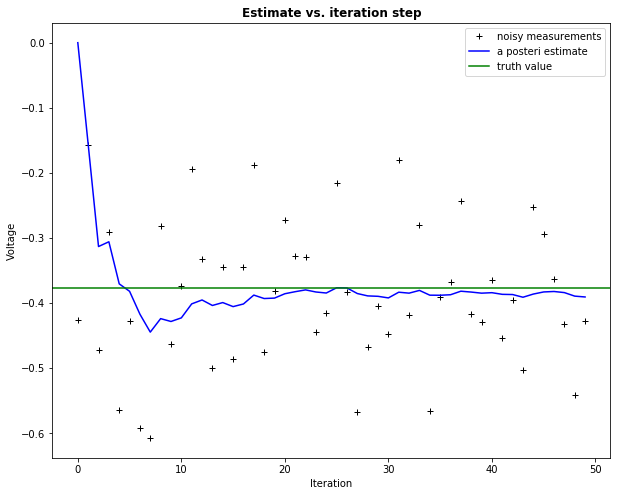

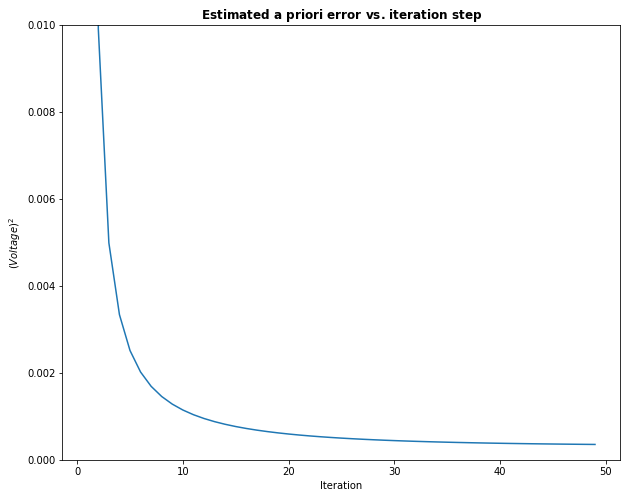

In [1]:
# Kalman filter example demo in Python

# A Python implementation of the example given in pages 11-15 of "An
# Introduction to the Kalman Filter" by Greg Welch and Gary Bishop,
# University of North Carolina at Chapel Hill, Department of Computer
# Science, TR 95-041,
# http://www.cs.unc.edu/~welch/kalman/kalmanIntro.html

# by Andrew D. Straw

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 8)

# intial parameters
n_iter = 50
sz = (n_iter,) # size of array
x = -0.37727 # truth value (typo in example at top of p. 13 calls this z)
z = np.random.normal(x,0.1,size=sz) # observations (normal about x, sigma=0.1)

Q = 1e-5 # process variance

# allocate space for arrays
xhat=np.zeros(sz)      # a posteri estimate of x
P=np.zeros(sz)         # a posteri error estimate
xhatminus=np.zeros(sz) # a priori estimate of x
Pminus=np.zeros(sz)    # a priori error estimate
K=np.zeros(sz)         # gain or blending factor

R = 0.1**2 # estimate of measurement variance, change to see effect

# intial guesses
xhat[0] = 0.0
P[0] = 1.0

for k in range(1,n_iter):
    # time update
    xhatminus[k] = xhat[k-1]
    Pminus[k] = P[k-1]+Q

    # measurement update
    K[k] = Pminus[k]/( Pminus[k]+R )
    xhat[k] = xhatminus[k]+K[k]*(z[k]-xhatminus[k])
    P[k] = (1-K[k])*Pminus[k]

plt.figure()
plt.plot(z,'k+',label='noisy measurements')
plt.plot(xhat,'b-',label='a posteri estimate')
plt.axhline(x,color='g',label='truth value')
plt.legend()
plt.title('Estimate vs. iteration step', fontweight='bold')
plt.xlabel('Iteration')
plt.ylabel('Voltage')

plt.figure()
valid_iter = range(1,n_iter) # Pminus not valid at step 0
plt.plot(valid_iter,Pminus[valid_iter],label='a priori error estimate')
plt.title('Estimated $\it{\mathbf{a \ priori}}$ error vs. iteration step', fontweight='bold')
plt.xlabel('Iteration')
plt.ylabel('$(Voltage)^2$')
plt.setp(plt.gca(),'ylim',[0,.01])
plt.show()


In [59]:
data = np.random.rand(100,15) # 5 entities, each contains 10 features
label = np.random.randint(6, size=100)
dtest = xgb.DMatrix([data[0]])
print(label.shape)
DQNAgent().xgbmodel_bld(data,label)
DQNAgent().bst.predict(dtest)
# np.argmax([DQNAgent().bst.predict(dtest),10])

(100,)
[0]	train-merror:0.41	eval-merror:0.41
Multiple eval metrics have been passed: 'eval-merror' will be used for early stopping.

Will train until eval-merror hasn't improved in 10 rounds.
[1]	train-merror:0.33	eval-merror:0.33
[2]	train-merror:0.25	eval-merror:0.25
[3]	train-merror:0.25	eval-merror:0.25
[4]	train-merror:0.26	eval-merror:0.26
[5]	train-merror:0.25	eval-merror:0.25
[6]	train-merror:0.19	eval-merror:0.19
[7]	train-merror:0.19	eval-merror:0.19
[8]	train-merror:0.18	eval-merror:0.18
[9]	train-merror:0.16	eval-merror:0.16
[10]	train-merror:0.17	eval-merror:0.17
[11]	train-merror:0.15	eval-merror:0.15
[12]	train-merror:0.15	eval-merror:0.15
[13]	train-merror:0.13	eval-merror:0.13
[14]	train-merror:0.13	eval-merror:0.13
[15]	train-merror:0.13	eval-merror:0.13
[16]	train-merror:0.13	eval-merror:0.13
[17]	train-merror:0.12	eval-merror:0.12
[18]	train-merror:0.13	eval-merror:0.13
[19]	train-merror:0.12	eval-merror:0.12
[20]	train-merror:0.13	eval-merror:0.13
[21]	train-merro

array([ 0.5], dtype=float32)